In [1]:
# Import required packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import keras
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
import tensorflow as tf
import os

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers import Input, Dense, BatchNormalization, Flatten, MaxPooling2D, Activation, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Multiply, Dropout, Subtract
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam, RMSprop, Nadam

## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

In [14]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'D:\\semester2\\Data science\\ads-spring2023-project3-group-9\\data\\train_data\\images\\{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('D:\\semester2\\Data science\\ads-spring2023-project3-group-9\\data\\train_data\\clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('D:\\semester2\\Data science\\ads-spring2023-project3-group-9\\data\\train_data\\noisy_labels.csv', delimiter=',', dtype="int8")

For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset. 

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


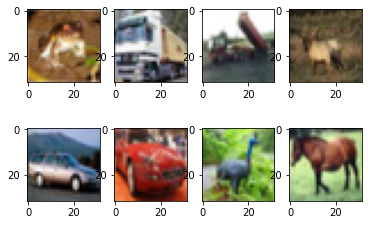

In [3]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))


## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [4]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [5]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [6]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

### 2.2. Model I

In [78]:
# [BUILD A MORE SOPHISTICATED PREDICTIVE MODEL]

# convert the 50000 noisy labels and images into numpy array for training test
# for train, the first element is the RGB matrix and the second element is the label
temp1 = []
for i in range(0, 50000):
    temp1.append([imgs[i],noisy_labels[i]])
train = np.array(temp1)

# convert the train array into two lists
x_train = []
y_train = []
for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

# normalize train variable
x_train = np.array(x_train) / 255
y_train = np.array(y_train)

# data augumentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range=0.2,  # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(x_train)

# define a simple CNN model with 3 Convolutional layers followed by max-pooling layers.
# A dropout layer is added after the 3rd maxpool operation to avoid overfitting.
model1 = Sequential()
model1.add(Conv2D(32, 3, padding="same", activation="relu", input_shape=(32, 32, 3)))
model1.add(MaxPool2D())
model1.add(Conv2D(32, 3, padding="same", activation="relu"))
model1.add(MaxPool2D())
model1.add(Conv2D(64, 3, padding="same", activation="relu"))
model1.add(MaxPool2D())
model1.add(Dropout(0.4))
model1.add(Flatten())
model1.add(Dense(128, activation="relu"))
model1.add(Dense(10, activation="softmax"))

model1.summary()

# complie model now using Adam as our optimizer and SparseCategoricalCrossentropy as the loss function.
# SE lower learning rate of 0.001 for a smoother curve.
opt = Adam(lr=0.001)
model1.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

# convert the 10000 clean labels and images into numpy array for testing
# for test, the first element is the RGB matrix and the second element is the label
temp2 = []
for i in range(0,10000):
    temp2.append([imgs[i],clean_labels[i]])
test = np.array(temp2)
#convert the test array into two lists
x_test = []
y_test = []
for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
#normalize variable
x_test = np.array(x_test) / 255
y_test = np.array(y_test)

# fitting the model
model1_history = model1.fit(x_train, y_train, epochs=15, validation_data=(x_test, y_test))
def model_I(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    dat = image / 255
    dat = np.reshape(dat, (1, 32, 32, 3))
    probs = model1.predict(dat)
    print(probs)
    return np.argmax(probs)   

C:\Users\Starbugs\AppData\Local\Temp/ipykernel_52636/1940536967.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train = np.array(temp1)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 4, 4, 64)        

C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\Starbugs\AppData\Local\Temp/ipykernel_52636/1940536967.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test = np.array(temp2)


Epoch 1/15


C:\ProgramData\Anaconda3\lib\site-packages\keras\backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 [==============================] - 24s 15ms/step - loss: 2.2764 - accuracy: 0.1481 - val_loss: 2.0562 - val_accuracy: 0.3203
Epoch 2/15
1563/1563 [==============================] - 23s 15ms/step - loss: 2.2455 - accuracy: 0.1867 - val_loss: 1.9746 - val_accuracy: 0.4024
Epoch 3/15
1563/1563 [==============================] - 23s 14ms/step - loss: 2.2278 - accuracy: 0.2003 - val_loss: 1.9140 - val_accuracy: 0.4534
Epoch 4/15
1563/1563 [==============================] - 23s 14ms/step - loss: 2.2142 - accuracy: 0.2145 - val_loss: 1.8752 - val_accuracy: 0.4845
Epoch 5/15
1563/1563 [==============================] - 22s 14ms/step - loss: 2.2032 - accuracy: 0.2242 - val_loss: 1.8155 - val_accuracy: 0.5006
Epoch 6/15
1563/1563 [==============================] - 22s 14ms/step - loss: 2.1927 - accuracy: 0.2313 - val_loss: 1.7911 - val_accuracy: 0.5236
Epoch 7/15
1563/1563 [==============================] - 23s 15ms/step - loss: 2.1812 - accuracy: 0.2382 - val_loss: 1.7635 - val_accura

### 2.3. Model II

In [8]:
train_clean_img=imgs[1000:10000] 
clean_labels_train=clean_labels[1000:10000]
noisy_labels_train= noisy_labels[1000:10000]
new_noisy_images=imgs[10000:]
new_noisy_labels=noisy_labels[10000:]
validation_split=0.2

In [9]:
#Build label cleaning model using images, and noisy labels as inputs, clean labels as outputs

#Define input layers
img_input = Input(shape=(32, 32, 3))
noisy_label = Input(shape=(10))

#Image feature extraction using pre-trained Resnet50
resnet = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(32, 32, 3),
    pooling='max'
)

img_vec = resnet(img_input)
img_vec = Dense(512)(img_vec)
img_vec = Dense(256)(img_vec)


noisy_l = Dense(10)(noisy_label)

#Concatenate both the noisy label and the image vector
x = Concatenate(axis=-1)([noisy_l, img_vec])
x = Dense(256, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

#data cleaning model
model2 = Model([img_input, noisy_label], output)

#Compile the model
model2.compile(loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[
              'acc'], optimizer=tf.keras.optimizers.Adam(0.001))

#Fit the cleaning model using the clean images
clean_labels_train = np.eye(10)[clean_labels_train]
noisy_labels_train = np.eye(10)[noisy_labels_train]
imgs_train = train_clean_img

callbacks = [
    EarlyStopping(patience=4)
]

model2.fit([imgs_train, noisy_labels_train], clean_labels_train, batch_size=128, epochs=9,
          validation_split=validation_split, callbacks=callbacks)

Epoch 1/9
57/57 [==============================] - 200s 3s/step - loss: 2.0246 - acc: 0.4258 - val_loss: 469.0044 - val_acc: 0.1089
Epoch 2/9
57/57 [==============================] - 194s 3s/step - loss: 1.4784 - acc: 0.5696 - val_loss: 165.1649 - val_acc: 0.3406
Epoch 3/9
57/57 [==============================] - 193s 3s/step - loss: 1.0478 - acc: 0.6728 - val_loss: 60.5225 - val_acc: 0.3850
Epoch 4/9
57/57 [==============================] - 192s 3s/step - loss: 0.7748 - acc: 0.7507 - val_loss: 1.8586 - val_acc: 0.6028
Epoch 5/9
57/57 [==============================] - 190s 3s/step - loss: 0.7696 - acc: 0.7599 - val_loss: 11.7388 - val_acc: 0.4833
Epoch 6/9
57/57 [==============================] - 191s 3s/step - loss: 0.8745 - acc: 0.7522 - val_loss: 1.9507 - val_acc: 0.3989
Epoch 7/9
57/57 [==============================] - 191s 3s/step - loss: 0.9014 - acc: 0.7451 - val_loss: 54.3228 - val_acc: 0.3200
Epoch 8/9
57/57 [==============================] - 189s 3s/step - loss: 0.5674 - ac

In [11]:
#Predict the noisy labels and pick up the max

cleaned_labels = model2.predict([new_noisy_images, np.eye(10)[new_noisy_labels]])

cleaned_labels = [np.argmax(i) for i in cleaned_labels]


1250/1250 [==============================] - 58s 46ms/step


In [88]:
#what happened?????
clean_labels_train=clean_labels[1000:10000]
#Rebuild the dataset, using the cleaned labels
x_train = np.concatenate((train_clean_img/255, new_noisy_images/255))
y_train = np.concatenate((clean_labels_train, np.array(cleaned_labels)))


In [58]:
# #Train final model (same as Model I) on cleaned data
# y_train = tf.one_hot(y_train, depth=10)

In [90]:
# define a simple CNN model with 3 Convolutional layers followed by max-pooling layers.
# A dropout layer is added after the 3rd maxpool operation to avoid overfitting.
final_model = Sequential()
final_model.add(Conv2D(32, 3, padding="same", activation="relu", input_shape=(32, 32, 3)))
final_model.add(MaxPool2D())
final_model.add(Conv2D(32, 3, padding="same", activation="relu"))
final_model.add(MaxPool2D())
final_model.add(Conv2D(64, 3, padding="same", activation="relu"))
final_model.add(MaxPool2D())
final_model.add(Dropout(0.4))
final_model.add(Flatten())
final_model.add(Dense(128, activation="relu"))
final_model.add(Dense(10, activation="softmax"))

final_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 4, 4, 64)        

In [93]:
# complie model now using Adam as our optimizer and SparseCategoricalCrossentropy as the loss function.
# SE lower learning rate of 0.001 for a smoother curve.
opt = Adam(lr=0.001)
final_model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [94]:
history = final_model.fit(x_train, y_train, batch_size=128, epochs=15, validation_split=validation_split, callbacks=callbacks)

Epoch 1/15
307/307 [==============================] - 15s 49ms/step - loss: 1.6978 - accuracy: 0.3821 - val_loss: 1.4554 - val_accuracy: 0.4793
Epoch 2/15
307/307 [==============================] - 15s 48ms/step - loss: 1.3789 - accuracy: 0.5005 - val_loss: 1.2785 - val_accuracy: 0.5492
Epoch 3/15
307/307 [==============================] - 15s 48ms/step - loss: 1.2664 - accuracy: 0.5480 - val_loss: 1.1512 - val_accuracy: 0.5886
Epoch 4/15
307/307 [==============================] - 15s 48ms/step - loss: 1.1883 - accuracy: 0.5738 - val_loss: 1.1960 - val_accuracy: 0.5697
Epoch 5/15
307/307 [==============================] - 15s 48ms/step - loss: 1.1354 - accuracy: 0.5904 - val_loss: 1.0501 - val_accuracy: 0.6231
Epoch 6/15
307/307 [==============================] - 15s 48ms/step - loss: 1.0930 - accuracy: 0.6035 - val_loss: 1.0438 - val_accuracy: 0.6283
Epoch 7/15
307/307 [==============================] - 15s 48ms/step - loss: 1.0610 - accuracy: 0.6210 - val_loss: 1.0098 - val_accuracy:

In [95]:
# [ADD WEAKLY SUPERVISED LEARNING FEATURE TO MODEL I]

def model_II(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    # write your code here...
    dat = image / 255
    dat = np.reshape(dat, (1, 32, 32, 3))
    probs = final_model.predict(dat)
    return np.argmax(probs)

## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose. 

In [96]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [97]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
# test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'D:\\semester2\\Data science\\ads-spring2023-project3-group-9\\data\\train_data\\images\\{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
# evaluation(baseline_model, test_labels, test_imgs)

The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.

In [98]:
test_images_normalized = test_imgs[:100] / 255.0

In [105]:
import pandas as pd
Index = []
Baseline = []
Model_I = []
Model_II =[]
True_label=[]
#test to change to 100


for i in range(100):
    img = test_imgs[i]
    Index.append(i+1)
    Baseline.append(baseline_model(img))
    Model_I.append(model_I(img))
    Model_II.append(model_II(img))

df = pd.DataFrame({
    'Index': Index,
    "baseline": Baseline,
    "model_I": Model_I,
    "model_II": Model_II
})
df.to_csv("label_prediction.csv", index=True, index_label="index")



1/1 [==============================] - 0s 13ms/step
[[0.07093465 0.07761347 0.09027311 0.08620404 0.12260325 0.09925147
  0.21062756 0.09251476 0.07835635 0.07162133]]
1/1 [==============================] - 0s 13ms/step
asd [[1.3050612e-04 1.1763666e-03 1.5489556e-02 6.2512852e-02 3.4599632e-02
  1.5292509e-01 6.6741306e-01 6.5549076e-02 2.4145485e-05 1.7967999e-04]]
1/1 [==============================] - 0s 13ms/step
[[0.05620849 0.05536453 0.13039604 0.04836864 0.09763066 0.15650053
  0.04170156 0.06193113 0.0665371  0.28536138]]
1/1 [==============================] - 0s 15ms/step
asd [[1.0683804e-04 8.6659389e-03 6.4522523e-04 1.8691553e-05 1.2554589e-05
  7.3605879e-05 2.6453133e-06 4.7521057e-04 5.0746487e-05 9.8994851e-01]]
1/1 [==============================] - 0s 15ms/step
[[0.10905401 0.07371412 0.07859609 0.07211298 0.09373153 0.088642
  0.09547675 0.09705763 0.11344072 0.17817411]]
1/1 [==============================] - 0s 13ms/step
asd [[1.6489335e-03 8.9264242e-03 1.504313

1/1 [==============================] - 0s 13ms/step
asd [[3.0064958e-04 1.4806481e-03 3.7439235e-02 1.1065481e-02 2.6630357e-02
  6.7257107e-04 9.2174107e-01 6.2303319e-05 1.8480471e-04 4.2294757e-04]]
1/1 [==============================] - 0s 14ms/step
[[0.0597541  0.06668126 0.0983256  0.1202965  0.1101462  0.09693012
  0.20657459 0.1004164  0.06948183 0.07139353]]
1/1 [==============================] - 0s 13ms/step
asd [[2.4970295e-04 1.1755120e-04 2.1447490e-01 2.5779024e-02 4.7543612e-01
  5.6024466e-04 2.8277263e-01 3.0195710e-04 5.3921147e-05 2.5393846e-04]]
1/1 [==============================] - 0s 13ms/step
[[0.07376757 0.08989336 0.11742457 0.11545204 0.05589695 0.13066325
  0.11962172 0.08192066 0.07302276 0.14233714]]
1/1 [==============================] - 0s 13ms/step
asd [[1.7431073e-02 3.3711498e-03 4.9763057e-01 4.6520069e-02 6.4975038e-02
  2.4398611e-01 5.1927087e-03 1.1919685e-01 8.8017077e-05 1.6084489e-03]]
1/1 [==============================] - 0s 14ms/step
[[0.04

1/1 [==============================] - 0s 13ms/step
asd [[6.7151588e-05 9.4795614e-01 1.3742149e-05 8.5212494e-05 7.2928939e-05
  1.3271547e-05 6.4990534e-05 5.2470765e-05 1.3912354e-04 5.1535130e-02]]
1/1 [==============================] - 0s 13ms/step
[[0.09127916 0.2474685  0.06121388 0.07343791 0.09368931 0.07831714
  0.0806906  0.05500109 0.10235219 0.1165502 ]]
1/1 [==============================] - 0s 13ms/step
asd [[1.9422485e-03 9.9632651e-01 2.1707917e-04 1.0401448e-04 1.6773914e-05
  5.5945264e-05 8.7545544e-05 1.3806151e-05 9.7424531e-04 2.6185246e-04]]
1/1 [==============================] - 0s 13ms/step
[[0.18858518 0.09598701 0.10262091 0.12285951 0.10822318 0.05148815
  0.07472632 0.07168048 0.12506033 0.05876893]]
1/1 [==============================] - 0s 13ms/step
asd [[5.3239381e-01 1.5161425e-03 1.1093183e-01 3.8888778e-03 2.7862489e-01
  5.2719726e-04 1.8548180e-04 1.9088532e-03 6.9797762e-02 2.2520826e-04]]
1/1 [==============================] - 0s 14ms/step
[[0.11

1/1 [==============================] - 0s 13ms/step
[[0.0430727  0.01322634 0.0414469  0.03617828 0.01892516 0.04095876
  0.04065146 0.71631145 0.03212322 0.01710572]]
1/1 [==============================] - 0s 13ms/step
asd [[2.47962715e-04 1.28982201e-05 1.21659611e-03 3.39295808e-03
  1.94931068e-02 7.88575187e-02 1.20592034e-04 8.96622181e-01
  5.58841066e-06 3.05776230e-05]]
1/1 [==============================] - 0s 14ms/step
[[0.1452615  0.04273972 0.06171856 0.0914979  0.06533368 0.08753715
  0.07091881 0.10811466 0.22293217 0.1039458 ]]
1/1 [==============================] - 0s 14ms/step
asd [[7.4304336e-01 5.4041343e-04 1.3694024e-01 1.2420450e-03 2.8540862e-03
  1.0925696e-04 1.4922950e-04 9.0293019e-05 1.1447207e-01 5.5906730e-04]]
1/1 [==============================] - 0s 14ms/step
[[0.1010277  0.10692187 0.11338506 0.11918724 0.09902301 0.08124983
  0.08074193 0.10102434 0.11263505 0.08480398]]
1/1 [==============================] - 0s 13ms/step
asd [[0.08834358 0.00250802 

1/1 [==============================] - 0s 14ms/step
[[0.07827557 0.08984952 0.07761978 0.13336715 0.10478242 0.09299629
  0.08038448 0.10712453 0.1604988  0.0751015 ]]
1/1 [==============================] - 0s 13ms/step
asd [[6.72938023e-03 1.80123025e-05 5.04892051e-01 2.66346335e-01
  3.42313871e-02 1.67675272e-01 2.07341881e-03 1.44198816e-02
  3.50975920e-03 1.04477265e-04]]
1/1 [==============================] - 0s 13ms/step
[[0.11652595 0.13355261 0.06815767 0.17753942 0.07657883 0.08173841
  0.03542879 0.11403225 0.10670348 0.08974254]]
1/1 [==============================] - 0s 14ms/step
asd [[0.3092202  0.00283016 0.00764358 0.19579451 0.13941637 0.13310339
  0.01564456 0.05042742 0.1281119  0.01780792]]
1/1 [==============================] - 0s 13ms/step
[[0.2089515  0.07818034 0.12774365 0.11589855 0.08094465 0.0607592
  0.07678529 0.03582817 0.12784635 0.08706231]]
1/1 [==============================] - 0s 13ms/step
asd [[6.2215978e-01 1.8954888e-01 2.2922514e-03 7.4897107e-